<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARIMA</font></b></strong>

**Modelos de Média Móvel Integrada Auto-Regressiva (ARIMA - Autoregressive Integrated Moving Average Models )**

ARIMA (p, d, q) 

O ARIMA é uma extensão natural da classe de modelos ARMA, que pode reduzir uma série não estacionária a uma série estacionária usando uma sequência de diferenças.

Uma série temporal x(t) é integrada na ordem d se diferenciar a série "d vezes", resultar em uma série discreta de ruído branco.

Uma série temporal x(t) é o modelo ARIMA (p, d, q) se a série diferir d vezes e, em seguida, seguir um processo ARMA (p, q).

Vamos simular um modelo ARIMA para nosso problema de negócio e verificar se conseguimos uma performance melhor do que tivemos com o modelo ARMA.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from pmdarima.arima.utils import ndiffs

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

scipy           1.5.4
statsmodels.api 0.12.1
pandas          1.1.5
sklearn         0.24.0
statsmodels     0.12.1
matplotlib      3.3.3
numpy           1.19.5
Data Science Academy


## Definição do Problema de Negócio

Previsão do distanciamento social em Minas Gerais.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

In [3]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2020-02-15,31.6
2020-02-16,38.9
2020-02-17,24.0
2020-02-18,26.5
2020-02-19,27.8


In [5]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

In [6]:
# Random seed 
np.random.seed(7)

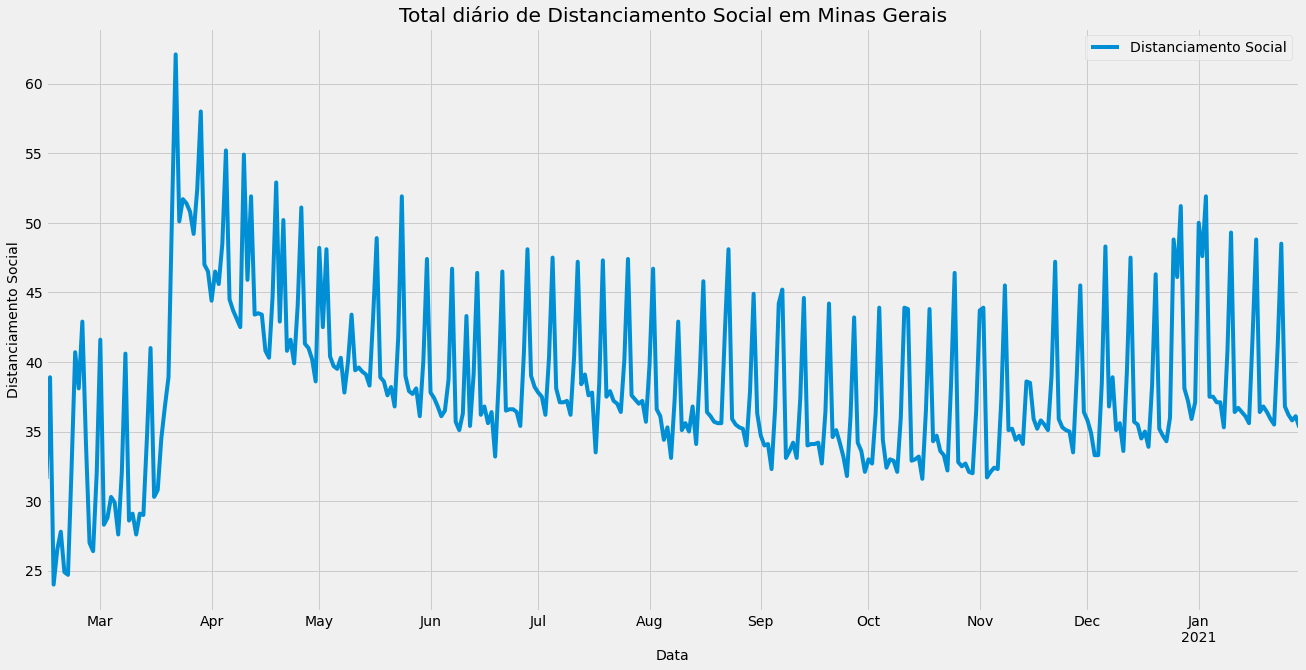

In [7]:
# Plot
target.plot(title = 'Total diário de Distanciamento Social em Minas Gerais', fontsize = 14, label = 'Distanciamento Social') 
plt.xlabel("Data") 
plt.ylabel("Distanciamento Social") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

262 88


In [9]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [11]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [12]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

O Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

A escolha é sua meu caro(a) Cientista de Dados.

In [13]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo ARIMA

Antes de criar o modelo ARIMA, vamos aplicar o conceito de Grid Search para encontrar a melhor combinação de valores para os parâmetros p, d e q.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

### Grid Search Para os Parâmetros p, d e q

In [14]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(X, arima_order):
    
    # Prepara os dados
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Previsões
    predictions = list()
    
    # Loop
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(method = 'mle', disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
      
    # Calcula o erro do modelo
    error = mean_squared_error(test, predictions)
    return error

In [15]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(dataset, p_values, d_values, q_values):
    
    # Ajusta o tipo dos dados
    dataset = dataset.astype('float32')
    
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = avalia_modelo_arima(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s   MSE = %.4f   RMSE = %.4f'% (order, mse, np.sqrt(mse)))
                except:
                    continue

    print('\nMelhor Modelo ARIMA%s   MSE = %.4f   RMSE = %.4f' % (best_cfg, best_score, np.sqrt(best_score)))

In [16]:
# Valores para o grid
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1] 
q_values = [0, 1, 2, 3, 4, 5] 

In [17]:
# Testando o melhor valor de p, d e q em os dados de treino
warnings.simplefilter("ignore")

avalia_melhor_arima(treino.values, p_values, d_values, q_values)

ARIMA(0, 0, 0)   MSE = 27.2998   RMSE = 5.2249
ARIMA(0, 0, 1)   MSE = 19.7437   RMSE = 4.4434
ARIMA(0, 0, 2)   MSE = 20.3960   RMSE = 4.5162
ARIMA(0, 0, 3)   MSE = 20.1434   RMSE = 4.4881
ARIMA(0, 0, 4)   MSE = 20.8612   RMSE = 4.5674
ARIMA(0, 0, 5)   MSE = 20.5002   RMSE = 4.5277
ARIMA(0, 1, 0)   MSE = 26.9843   RMSE = 5.1946
ARIMA(0, 1, 1)   MSE = 22.9732   RMSE = 4.7930
ARIMA(0, 1, 2)   MSE = 19.2069   RMSE = 4.3826
ARIMA(0, 1, 3)   MSE = 19.3009   RMSE = 4.3933
ARIMA(0, 1, 4)   MSE = 18.3510   RMSE = 4.2838
ARIMA(0, 1, 5)   MSE = 19.6123   RMSE = 4.4286
ARIMA(1, 0, 0)   MSE = 20.6964   RMSE = 4.5493
ARIMA(1, 0, 1)   MSE = 23.8104   RMSE = 4.8796
ARIMA(1, 0, 2)   MSE = 19.0664   RMSE = 4.3665
ARIMA(1, 0, 3)   MSE = 20.3205   RMSE = 4.5078
ARIMA(1, 0, 4)   MSE = 20.8025   RMSE = 4.5610
ARIMA(1, 0, 5)   MSE = 23.5765   RMSE = 4.8556
ARIMA(1, 1, 0)   MSE = 27.2377   RMSE = 5.2190
ARIMA(1, 1, 1)   MSE = 20.0598   RMSE = 4.4788
ARIMA(1, 1, 2)   MSE = 20.2231   RMSE = 4.4970
ARIMA(1, 1, 3

As mensagens de warning acima indicam que as algumas combinações testadas não fazem o modelo nem mesmo convergir.

De acordo com o resultado, os melhores valores são: order = (4,1,5). 

## Vamos fazer previsões com o modelo Forecast usando 'ARIMA'

In [166]:
# Modelo
modelo_AR = ARIMA(treino, order = (4, 1, 5))

C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [167]:
# Treinamento
#modelo_v1 = modelo_AR.fit(disp = -1)  
modelo_v1 = modelo_AR.fit(method = 'mle', disp = False)

C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [168]:
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.QT_INTER   No. Observations:                  261
Model:                 ARIMA(4, 1, 5)   Log Likelihood                -681.567
Method:                           mle   S.D. of innovations              3.222
Date:                Sun, 07 Feb 2021   AIC                           1385.134
Time:                        12:21:40   BIC                           1424.344
Sample:                    02-16-2020   HQIC                          1400.895
                         - 11-02-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0361      0.076      0.472      0.637      -0.114       0.186
ar.L1.D.QT_INTER     0.8022   2.75e-06   2.92e+05      0.000       0.802       0.802
ar.L2.D.QT_INTER    -1.4462    7.7e-07  -1.88e+06      0.000      -1.446      -1.446
ar.L3.D.QT_INTER     0.8047   4.91e-08   1.64e+07      0.000       0.805       0.805
ar.L4.D.QT_INTER    -0.9944   1.73e-05  -5.75e+04      0.000      -0.994      -0.994
ma.L1.D.QT_INTER    -1.3671      0.046    -29.476      0.000      -1.458      -1.276
ma.L2.D.QT_INTER     1.8675      0.046     40.407      0.000       1.777       1.958
ma.L3.D.QT_INTER    -1.6429      0.068    -24.112      0.000      -1.776      -1.509
ma.L4.D.QT_INTER     1.4098      0.040     35.410      0.000       1.332       1.488
ma.L5.D.QT_INTER    -0.5693      0.059     -9.592      0.000      -0.686      -0.453
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6251           -0.7841j            1.0028           -0.1429
AR.2            0.6251           +0.7841j            1.0028            0.1429
AR.3           -0.2205           -0.9754j            1.0000           -0.2854
AR.4           -0.2205           +0.9754j            1.0000            0.2854
MA.1           -0.2201           -0.9763j            1.0008           -0.2853
MA.2           -0.2201           +0.9763j            1.0008            0.2853
MA.3            0.6409           -0.8136j            1.0357           -0.1438
MA.4            0.6409           +0.8136j            1.0357            0.1438
MA.5            1.6348           -0.0000j            1.6348           -0.0000
-----------------------------------------------------------------------------
"""

In [169]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste), alpha = 0.05) 

# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste.index)
limite_inferior = pd.Series(conf[:, 0], index = teste.index)
limite_superior = pd.Series(conf[:, 1], index = teste.index)

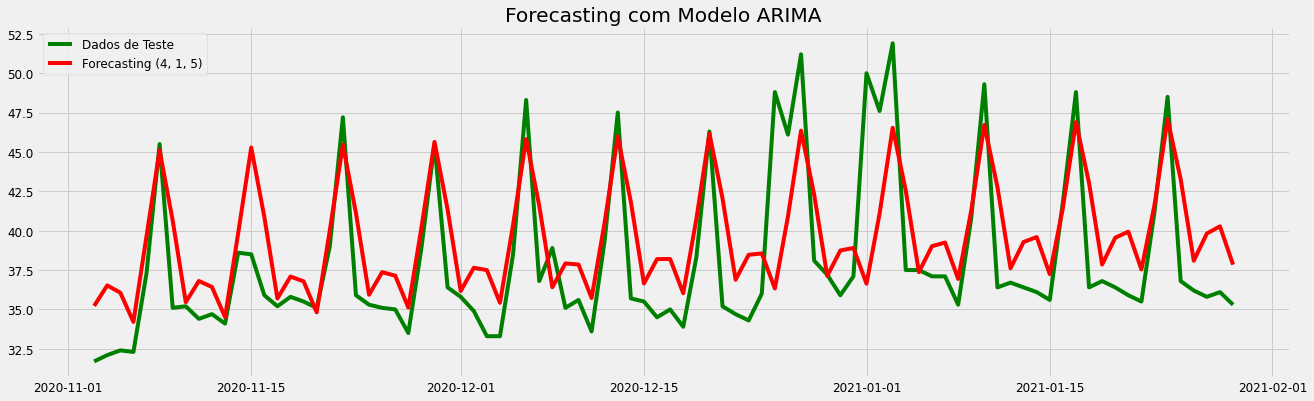

In [170]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (4, 1, 5)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [171]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 14.0723
RMSE das previsões é 3.7513
MAPE das previsões é 7.6093


## Vamos fazer previsões com o modelo usando 'ARIMA'

In [172]:
# Cria o modelo com os dados de treino
modelo_arima = ARIMA(treino, order = (4, 1, 5))

C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [173]:
# Treina o modelo
#modelo_arima_fit = modelo_arima.fit(disp = -1)  
modelo_arima_fit = modelo_arima.fit(method = 'mle', disp = False)

C:\Users\Guto\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [174]:
# Sumário do modelo
modelo_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.QT_INTER   No. Observations:                  261
Model:                 ARIMA(4, 1, 5)   Log Likelihood                -681.567
Method:                           mle   S.D. of innovations              3.222
Date:                Sun, 07 Feb 2021   AIC                           1385.134
Time:                        12:23:43   BIC                           1424.344
Sample:                    02-16-2020   HQIC                          1400.895
                         - 11-02-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0361      0.076      0.472      0.637      -0.114       0.186
ar.L1.D.QT_INTER     0.8022   2.75e-06   2.92e+05      0.000       0.802       0.802
ar.L2.D.QT_INTER    -1.4462    7.7e-07  -1.88e+06      0.000      -1.446      -1.446
ar.L3.D.QT_INTER     0.8047   4.91e-08   1.64e+07      0.000       0.805       0.805
ar.L4.D.QT_INTER    -0.9944   1.73e-05  -5.75e+04      0.000      -0.994      -0.994
ma.L1.D.QT_INTER    -1.3671      0.046    -29.476      0.000      -1.458      -1.276
ma.L2.D.QT_INTER     1.8675      0.046     40.407      0.000       1.777       1.958
ma.L3.D.QT_INTER    -1.6429      0.068    -24.112      0.000      -1.776      -1.509
ma.L4.D.QT_INTER     1.4098      0.040     35.410      0.000       1.332       1.488
ma.L5.D.QT_INTER    -0.5693      0.059     -9.592      0.000      -0.686      -0.453
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6251           -0.7841j            1.0028           -0.1429
AR.2            0.6251           +0.7841j            1.0028            0.1429
AR.3           -0.2205           -0.9754j            1.0000           -0.2854
AR.4           -0.2205           +0.9754j            1.0000            0.2854
MA.1           -0.2201           -0.9763j            1.0008           -0.2853
MA.2           -0.2201           +0.9763j            1.0008            0.2853
MA.3            0.6409           -0.8136j            1.0357           -0.1438
MA.4            0.6409           +0.8136j            1.0357            0.1438
MA.5            1.6348           -0.0000j            1.6348           -0.0000
-----------------------------------------------------------------------------
"""

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

## Previsão com o modelo treinado - Predict

In [175]:
# Predict
# Previsões com o modelo (passamos somente as datas e o modelo prevê os valores)
arima_predict = modelo_arima_fit.predict(start = pd.to_datetime('2020-11-02'), 
                                         end = pd.to_datetime('2021-01-29'),
                                         dynamic = False)

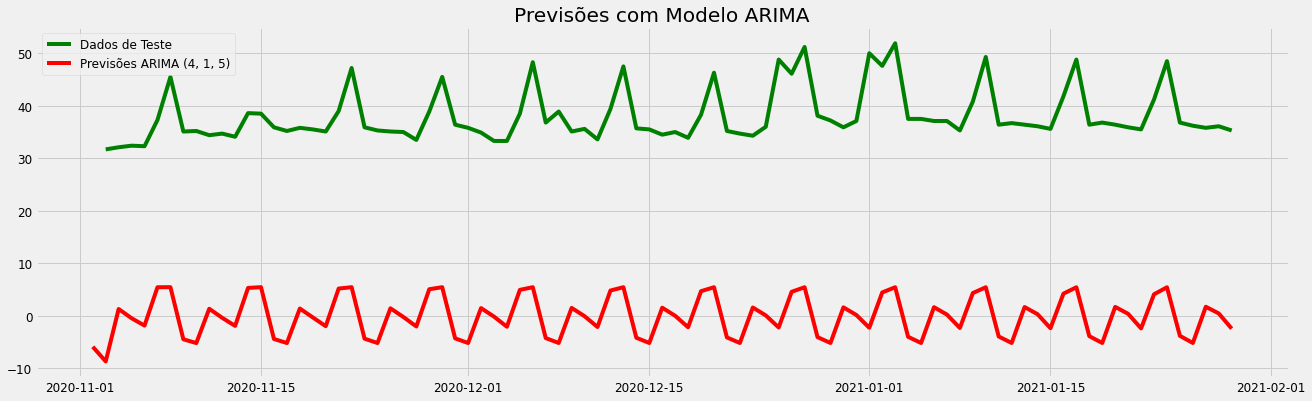

In [176]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (4, 1, 5)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

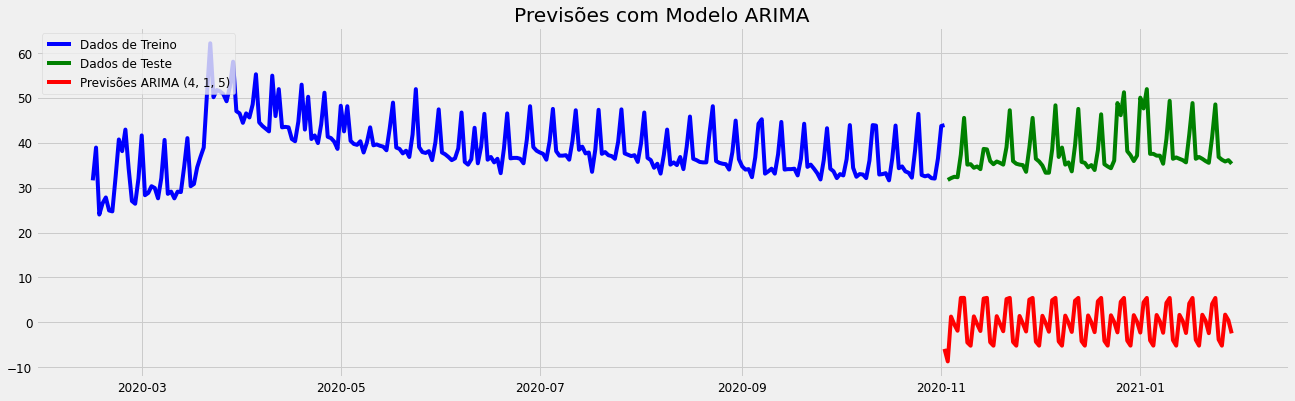

In [178]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (4, 1, 5)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [179]:
# Calculando a performance
arima_results = performance(teste, arima_predict)
#arima_results

MSE das previsões é 1474.1854
RMSE das previsões é 38.3951
MAPE das previsões é 100.8682


Vamos executar alguns diagnósticos para avaliar o modelo.

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [180]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.00000000  -  Os resíduos podem não ser normalmente distribuídos.


In [181]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [1.61961608e-51]


Observe que o valor-p é menor que 0,05, o que indica que os resíduos não são independentes no nível de 95% e, portanto, um modelo ARIMA (2,0,1) não fornece um bom ajuste do modelo.

Como estamos até agora:

- Modelo 15 --> Modelo ARMA (9, 6) - AIC = 1295.100 e RMSE = 3.5966
- Modelo 16 --> Modelo ARIMA Forcast (4, 1, 5) Forecast - AIC = 1385.134 e RMSE = 3.7513

Com o modelo ARIMA conseguimos reduzir o erro total do modelo, embora o AIC tenha aumentado um pouco. O ARIMA Predict não convergiu.

O modelo ARIMA consegue um ajuste aos dados, mas é muito pior que o modelo ARMA.

Vamos ver o que conseguimos com um modelo mais avançado, o SARIMA. Na próxima aula. 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim